In [1]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots","PyCall","JSON","JLD2","FileIO","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using Statistics: mean
using Plots;
using FileIO;
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, Param,progress, sgd,dropout, relu,
Data,sigm, xavier,gpu,softmax
import Knet:param,param0
using Images;
using PyCall,JSON,JLD2,Random
@pyimport numpy as np 

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:400
└ @ PyCall /home/ege/.julia/packages/PyCall/RQjD7/src/PyCall.jl:400


In [2]:
atype()=(gpu() >= 0 ? KnetArray{Float32} : Array{Float32})
param(d...; init=xavier, atype=atype())=Param(atype(init(d...)))
param0(d...; atype=atype())=param(d...; init=zeros, atype=atype)

param0 (generic function with 1 method)

In [3]:
struct Chain
    layers
    Chain(layers...)=new(layers)
end
(c::Chain)(x) = (for layer in c.layers; x=layer(x) ;println(size(x));end; x) #layerların çıktılarını hesaplayıp son layerın çıktısını veriyor
(c::Chain)(x,y)=nll(c(x),y) #loss
(c::Chain)(d::Data)=mean(c(x,y) for (x,y) in d) #batch için mean loss hesapla

In [4]:
struct Fully; w;b;func;end;
Fully(m::Int,n::Int,func)=Fully(param(n,m),param0(n),func)
(ful::Fully)(x)=ful.func.(ful.w*x.+ful.b)

In [5]:
struct Conv; w;b;func;
    Conv(w,b)=new(w,b,relu)
    end;
#Conv(w,b,func=relu)=new(w,b)#w,b,func) #kendini call ediyor problem ouyor
(c::Conv)(x)=c.func.(conv4(c.w,x,padding=1).+c.b) 

In [6]:
struct Pool end
(p::Pool)(x)=pool(x)

In [7]:
struct Dense; w;b;func;
    Dense(w,b)=new(w,b,relu)
    Dense(w,b,func)=new(w,b,func)
    end;
#Dense(m::Int,n::Int,func=relu)=Dense(param(n,m),param0(n),func)
(den::Dense)(x)=den.func.(transpose(den.w)*mat(x).+den.b)

In [8]:
vgg_load=np.load("vgg16_weights.npz")

PyObject <numpy.lib.npyio.NpzFile object at 0x7f62a00e7e48>

In [9]:
size(w_arr[29])

UndefVarError: UndefVarError: w_arr not defined

In [10]:
weight_keys=sort(collect(vgg_load."files"));

In [11]:
w_arr=[]
for elem in weight_keys
    w=get(vgg_load,elem)
    println(size(w))
    if occursin("b",elem)&&occursin("conv",elem)
       push!(w_arr,reshape(w,(1,1,size(w)[1],1)))
    else
        push!(w_arr,w)
    end
end

(3, 3, 3, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 128, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(25088, 4096)
(4096,)
(4096, 4096)
(4096,)
(4096, 1000)
(1000,)


In [12]:
@doc softmax

```
softmax(x; dims=1, algo=1)
```

The softmax function typically used in classification. Gives the same results as to `exp.(logp(x, dims))`. 

If `algo=1` computation is more accurate, if `algo=0` it is  faster. 

See also `logsoftmax`.


In [13]:
@doc Knet.logp

```
logp(x; dims=:)
```

Treat entries in `x` as as unnormalized log probabilities and return normalized log probabilities.

`dims` is an optional argument, if not specified the normalization is over the whole `x`, otherwise the normalization is performed over the given dimensions.  In particular, if `x` is a matrix, `dims=1` normalizes columns of `x` and `dims=2` normalizes rows of `x`.


In [42]:
function sof(x)
    exp.(Knet.logp(x,dims=1))
end

sof (generic function with 1 method)

In [47]:
sof([2, 3, 5, 6])

4-element Array{Float64,1}:
 0.01275478174208794 
 0.034671091435478855
 0.25618663962790716 
 0.696387487194526   

In [49]:
Vgg_model=Chain(Conv(w_arr[1],w_arr[2]),Conv(w_arr[3],w_arr[4]),Pool(),  #layer1
    Conv(w_arr[5],w_arr[6]),Conv(w_arr[7],w_arr[8]),Pool(),              #layer2
    Conv(w_arr[9],w_arr[10]),Conv(w_arr[11],w_arr[12]),Conv(w_arr[13],w_arr[14]),Pool(),       #layer3
    Conv(w_arr[15],w_arr[16]),Conv(w_arr[17],w_arr[18]),Conv(w_arr[19],w_arr[20]),Pool(),       #layer4
    Conv(w_arr[21],w_arr[22]),Conv(w_arr[23],w_arr[24]),Conv(w_arr[25],w_arr[26]),Pool(),       #layer5
    Dense(w_arr[27],w_arr[28]),Dense(w_arr[29],w_arr[30]),Dense(w_arr[31],w_arr[32],identity));           #prediction burada

In [16]:
#son layerda identity olması gerek nll dde zaten softmax var
#resimler 0-255 deği 0-1








img=load("dalmat.jpg");

In [17]:
img2=convert(Array{Float64},img);

MethodError: MethodError: Cannot `convert` an object of type RGB{Normed{UInt8,8}} to an object of type Float64
Closest candidates are:
  convert(::Type{T<:AbstractFloat}, !Matched::Ratios.SimpleRatio{S}) where {T<:AbstractFloat, S} at /home/ege/.julia/packages/Ratios/iJ67w/src/Ratios.jl:16
  convert(::Type{T<:Number}, !Matched::T<:Number) where T<:Number at number.jl:6
  convert(::Type{T<:Number}, !Matched::Number) where T<:Number at number.jl:7
  ...

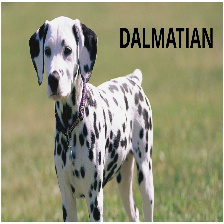

In [18]:
img2=colorview(RGB, img)

In [19]:
matrix_ran=rand(224,224,3)
matrix_ran=reshape(matrix_ran,(224,224,3,1));
matrix_ran=convert(Array{Float32},matrix_ran);

In [20]:
img2=reshape(img,(224,224,3,1))

DimensionMismatch: DimensionMismatch("new dimensions (224, 224, 3, 1) must be consistent with array size 50176")

In [21]:
a=rand(224,224,3,1)
a=convert(Array{Float32},a);

In [27]:
dog_img_load=np.load("dog.npz")
dog_img=get(dog_img_load,"arr_0.npy")
size(dog_img)
dog_img[1]
#dog_img=reshape(dog_img,(224,224,3,1)); #0-255 resim
#dog_img=convert(Array{Float32},dog_img);

In [50]:
pred=Vgg_model(dog_img)

(224, 224, 64, 1)
(224, 224, 64, 1)
(112, 112, 64, 1)
(112, 112, 128, 1)
(112, 112, 128, 1)
(56, 56, 128, 1)
(56, 56, 256, 1)
(56, 56, 256, 1)
(56, 56, 256, 1)
(28, 28, 256, 1)
(28, 28, 512, 1)
(28, 28, 512, 1)
(28, 28, 512, 1)
(14, 14, 512, 1)
(14, 14, 512, 1)
(14, 14, 512, 1)
(14, 14, 512, 1)
(7, 7, 512, 1)
(4096, 1)
(4096, 1)
(1000, 1)


1000×1 Array{Float32,2}:
 -0.461573  
 -0.61419666
  0.22494003
 -0.4311269 
  0.06965382
  0.2539807 
  0.51616246
  0.17086688
 -0.12854789
 -0.7060391 
 -1.1848333 
 -1.0675917 
 -0.6197882 
  ⋮         
 -0.6031982 
 -1.4214864 
 -1.1431565 
 -1.7194108 
 -1.4293762 
 -1.9603561 
 -2.1720572 
 -1.259527  
 -0.7439387 
 -1.0658036 
  0.58047736
  0.7707866 

In [62]:
i=0
preds_soft=sof(pred)
max_elem=preds_soft[1]
for j=2:size(preds_soft,1)
   #println(pred[j-1],pred[j])
    if max_elem<preds_soft[j]
        println(max_elem,"   ",preds_soft[j])
        max_elem=preds_soft[j]
        i=j
    end
end

0.00046941027,0.0009326128
0.0009326128,0.00096009375
0.00096009375,0.0012478934
0.0012478934,0.0015188933
0.0015188933,0.0020924208
0.0020924208,0.003764763
0.003764763,0.004821767
0.004821767,0.004902185
0.004902185,0.0058413483


In [60]:
i

838

In [57]:
max_elem

0.0058413483f0